# Lecture 2 - Neural network deep dive

> A deep dive into optimising neural networks with gradient descent

## Learning objectives

* Understand what gradient descent is and how to implement it in PyTorch
* Understand how to put a `Learner` together

## References

* Chapter 4 of [_Deep Learning for Coders with fastai & PyTorch_](https://github.com/fastai/fastbook) by Jeremy Howard and Sylvain Gugger.

## Imports

In [69]:
import torch
from datasets import load_dataset
from fastai.tabular.all import *
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

## Stochastic gradient descent

To illustrate how the gradient descent process works, let's consider a simple quadratic loss function, where `x` is a weight parameter that we wish to estimate:

In [5]:
def loss(x):
    return x**2

In [7]:
xt = tensor(3.0).requires_grad_()
xt

tensor(3., requires_grad=True)

In [8]:
yt = f(xt)
yt

tensor(9., grad_fn=<PowBackward0>)

In [9]:
yt.backward()

In [10]:
xt.grad

tensor(6.)

In [12]:
xt = tensor([3.0, 4.0, 10.0]).requires_grad_()
xt

tensor([ 3.,  4., 10.], requires_grad=True)

In [13]:
def f(x):
    return (x**2).sum()


yt = f(xt)
yt

tensor(125., grad_fn=<SumBackward0>)

In [14]:
yt.backward()
xt.grad

tensor([ 6.,  8., 20.])

w = -= w.grad * lr

## An end-to-end example

In [40]:
time = torch.arange(0, 20).float()
time

tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15., 16., 17., 18., 19.])

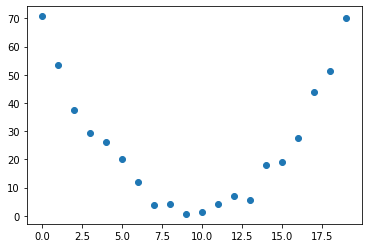

In [41]:
speed = torch.randn(20) * 3 + 0.75 * (time - 9.5) ** 2 + 1
plt.scatter(time, speed);

In [42]:
def f(t, params):
    a, b, c = params
    return a * (t**2) + (b * t) + c

In [43]:
def mse(preds, targets):
    return ((preds - targets) ** 2).mean()

### Step 1: Initialize the parameters

In [44]:
params = torch.randn(3).requires_grad_()

### Step 2: Calculate the predictions

In [45]:
preds = f(time, params)

In [46]:
def show_preds(preds, ax=None):
    if ax is None:
        ax = plt.subplots()[1]
    ax.scatter(time, speed)
    ax.scatter(time, to_np(preds), color="red")
    ax.set_ylim(-300, 100)

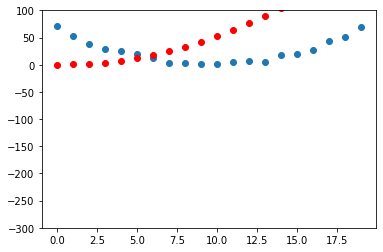

In [47]:
show_preds(preds)

### Step 3: Calculate the loss

In [48]:
loss = mse(preds, speed)
loss

tensor(5268.0308, grad_fn=<MeanBackward0>)

### Step 4: Calculate the gradients

In [49]:
loss.backward()
params.grad

tensor([22863.0625,  1462.5667,    81.2762])

In [47]:
params.grad * 1e-5

tensor([0.6934, 0.0446, 0.0029])

In [48]:
params

tensor([ 1.3324,  0.7078, -0.8501], requires_grad=True)

### Step 5: Step the weights

In [50]:
lr = 1e-5
params.data -= lr * params.data
params.grad = None

In [51]:
preds = f(time, params)
mse(preds, speed)

tensor(5267.9082, grad_fn=<MeanBackward0>)

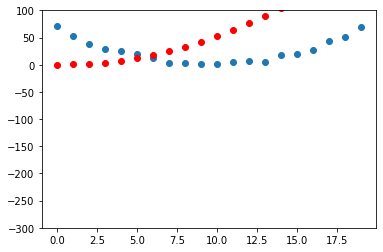

In [52]:
show_preds(preds)

In [53]:
def apply_step(params, prn=True):
    preds = f(time, params)
    loss = mse(preds, speed)
    loss.backward()
    params.data -= lr * params.grad.data
    params.grad = None
    if prn:
        print(loss.item())
    return preds

### Step 6: Repeat the process

In [54]:
for i in range(10):
    apply_step(params)

5267.908203125
1502.0821533203125
789.4694213867188
654.6181030273438
629.0969848632812
624.2644653320312
623.3468017578125
623.1699829101562
623.1334228515625
623.1233520507812


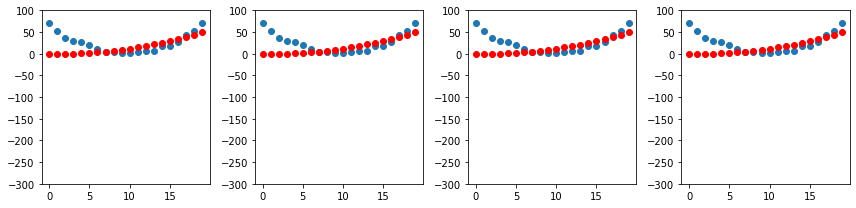

In [55]:
_, axs = plt.subplots(1, 4, figsize=(12, 3))
for ax in axs:
    show_preds(apply_step(params, False), ax)
plt.tight_layout()

### Step 7: Stop

## Binary cross entropy loss function

In [56]:
nsubjet_ds = load_dataset("dl4phys/top_tagging_nsubjettiness")
nsubjet_ds.set_format("pt")

Using custom data configuration dl4phys--top_tagging_nsubjettiness-d7eca4f13187c4c4
Reusing dataset parquet (/home/lewis/.cache/huggingface/datasets/parquet/dl4phys--top_tagging_nsubjettiness-d7eca4f13187c4c4/0.0.0/0b6d5799bb726b24ad7fc7be720c170d8e497f575d02d47537de9a5bac074901)


  0%|          | 0/3 [00:00<?, ?it/s]

In [57]:
nsubjet_ds["train"][0]

{'pT': tensor(543.6340),
 'mass': tensor(25.8468),
 'tau_1_0.5': tensor(0.1651),
 'tau_1_1': tensor(0.0327),
 'tau_1_2': tensor(0.0023),
 'tau_2_0.5': tensor(0.0488),
 'tau_2_1': tensor(0.0037),
 'tau_2_2': tensor(4.3910e-05),
 'tau_3_0.5': tensor(0.0310),
 'tau_3_1': tensor(0.0016),
 'tau_3_2': tensor(1.1182e-05),
 'tau_4_0.5': tensor(0.0243),
 'tau_4_1': tensor(0.0011),
 'tau_4_2': tensor(7.7659e-06),
 'tau_5_0.5': tensor(0.0043),
 'tau_5_1': tensor(0.0002),
 'tau_5_2': tensor(7.7060e-07),
 'tau_6_0.5': tensor(0.),
 'tau_6_1': tensor(0.),
 'tau_6_2': tensor(0.),
 'label': tensor(0)}

* Create PyTorch dataset from list of xs and ys
* Define cross entropy
* Define network etc

In [62]:
def binary_cross_entropy(predictions, targets):
    predictions = predictions.sigmoid()
    return -torch.where(targets == 1, predictions, 1 - predictions).log().mean()

In [63]:
targs = tensor([1, 0, 1])
preds = tensor([0.9, 0.4, 0.2])

In [64]:
preds.sigmoid()

tensor([0.7109, 0.5987, 0.5498])

In [65]:
binary_cross_entropy(preds, targs)

tensor(0.6174)

## Nsubs

In [66]:
nsubjet_ds = load_dataset("dl4phys/top_tagging_nsubjettiness")

Using custom data configuration dl4phys--top_tagging_nsubjettiness-d7eca4f13187c4c4
Reusing dataset parquet (/home/lewis/.cache/huggingface/datasets/parquet/dl4phys--top_tagging_nsubjettiness-d7eca4f13187c4c4/0.0.0/0b6d5799bb726b24ad7fc7be720c170d8e497f575d02d47537de9a5bac074901)


  0%|          | 0/3 [00:00<?, ?it/s]

In [125]:
sample_ds = nsubjet_ds["train"].shuffle(42).select(range(100_000))

Loading cached shuffled indices for dataset at /home/lewis/.cache/huggingface/datasets/parquet/dl4phys--top_tagging_nsubjettiness-d7eca4f13187c4c4/0.0.0/0b6d5799bb726b24ad7fc7be720c170d8e497f575d02d47537de9a5bac074901/cache-ebc5a2cef88f6535.arrow


In [126]:
df = sample_ds.to_pandas()
df.head()

,pT,mass,tau_1_0.5,tau_1_1,tau_1_2,tau_2_0.5,tau_2_1,tau_2_2,tau_3_0.5,tau_3_1,...,tau_4_0.5,tau_4_1,tau_4_2,tau_5_0.5,tau_5_1,tau_5_2,tau_6_0.5,tau_6_1,tau_6_2,label
0,338.439987,71.581491,0.435293,0.196073,0.044447,0.296234,0.099891,0.013279,0.136720,0.022818,...,0.111311,0.016025,5.311108e-04,0.089107,0.010286,0.000179,0.073085,0.007559,0.000104,1
1,504.319316,146.443335,0.449218,0.226846,0.083395,0.242954,0.073341,0.014817,0.153284,0.027964,...,0.136054,0.022821,1.021361e-03,0.108123,0.015077,0.000497,0.052981,0.007703,0.000374,1
2,417.716371,102.312186,0.448027,0.214367,0.059335,0.191716,0.051882,0.007526,0.152479,0.027048,...,0.135582,0.021348,7.622883e-04,0.083184,0.012764,0.000463,0.056078,0.007543,0.000256,1
3,503.162877,75.285580,0.372784,0.143807,0.022370,0.198613,0.044480,0.003666,0.136230,0.026184,...,0.112351,0.019649,1.545010e-03,0.103593,0.014726,0.000451,0.091963,0.011852,0.000342,1
4,534.851410,37.254168,0.235412,0.059534,0.004854,0.063862,0.008537,0.000800,0.031380,0.001747,...,0.012181,0.000332,9.012786e-07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0


In [127]:
train_df, valid_df = train_test_split(df)

In [128]:
scaler = StandardScaler()

In [129]:
train_x, valid_x = scaler.fit_transform(train_df.iloc[:, :-1]), scaler.fit_transform(
    valid_df.iloc[:, :-1]
)

In [130]:
train_x, train_y = torch.from_numpy(train_x).float(), torch.from_numpy(
    train_df.iloc[:, -1].values
)
valid_x, valid_y = torch.from_numpy(valid_x).float(), torch.from_numpy(
    valid_df.iloc[:, -1].values
)

In [131]:
train_x[0]

tensor([-0.1688,  0.9141,  0.7808,  0.1930, -0.1225,  0.7491,  0.3270, -0.0683,
         0.5274,  0.0452, -0.0679,  0.7423,  0.2469, -0.0494,  1.0436,  0.4255,
        -0.0370,  1.1981,  0.4918, -0.0294])

In [132]:
train_y[0]

tensor(1)

In [133]:
train_dset = list(zip(train_x, train_y))
valid_dset = list(zip(valid_x, valid_y))

In [134]:
x, y = train_dset[0]
x.shape, y

(torch.Size([20]), tensor(1))

In [135]:
def init_params(size, std=1.0):
    return (torch.randn(size) * std).requires_grad_()


weights = init_params((20, 1))

In [136]:
bias = init_params(1)

In [137]:
(train_x[0] * weights.T).sum() + bias

tensor([-0.8978], grad_fn=<AddBackward0>)

In [138]:
def linear1(xb):
    return xb @ weights + bias


preds = linear1(train_x)
preds[:10]

tensor([[-0.8978],
        [ 1.4321],
        [-0.2015],
        [ 0.6350],
        [-2.4364],
        [ 1.0395],
        [-1.0279],
        [ 0.7718],
        [ 1.8247],
        [ 0.8250]], grad_fn=<SliceBackward0>)

### GD and mini-batches

In [139]:
coll = range(15)
dl = DataLoader(coll, batch_size=5, shuffle=True)
list(dl)

[tensor([ 0, 13,  9,  2, 11]),
 tensor([ 7,  8, 14,  4, 10]),
 tensor([ 1,  6,  5,  3, 12])]

In [140]:
weights = init_params((20, 1))
bias = init_params(1)

In [141]:
train_dl = DataLoader(train_dset, batch_size=256, shuffle=True)
(
    xb,
    yb,
) = first(train_dl)
xb.shape, yb.shape

(torch.Size([256, 20]), torch.Size([256]))

In [142]:
valid_dl = DataLoader(valid_dset, batch_size=256)

In [143]:
batch = train_x[:4]
batch.shape

torch.Size([4, 20])

In [144]:
preds = linear1(batch)

In [145]:
train_y[:4]

tensor([1, 0, 1, 0])

In [146]:
loss = binary_cross_entropy(preds, train_y[:4])
loss

tensor(0.7756, grad_fn=<NegBackward0>)

In [147]:
loss.backward()
weights.grad.shape, weights.grad.mean(), bias.grad

(torch.Size([20, 1]), tensor(-0.0863), tensor([-0.0018]))

In [148]:
def calc_grad(xb, yb, model):
    preds = model(xb)
    loss = binary_cross_entropy(preds, yb)
    loss.backward()

In [149]:
calc_grad(batch, train_y[:4], linear1)

In [150]:
weights.grad.mean(), bias.grad

(tensor(-0.1726), tensor([-0.0035]))

In [175]:
simple_net = nn.Sequential(
    nn.BatchNorm1d(20),
    nn.Linear(20, 200),
    nn.ReLU(),
    nn.Linear(200, 200),
    nn.ReLU(),
    nn.Linear(200, 50),
    nn.ReLU(),
    nn.Linear(50, 50),
    nn.ReLU(),
    nn.Linear(50, 1),
)

In [176]:
dls = DataLoaders(train_dl, valid_dl)

In [181]:
learn = Learner(dls, simple_net, opt_func=SGD, loss_func=binary_cross_entropy, metrics=[accuracy, RocAucBinary()])

In [182]:
learn.summary()

Sequential (Input shape: 256 x 20)
Layer (type)         Output Shape         Param #    Trainable 
                     256 x 20            
BatchNorm1d                               40         True      
____________________________________________________________________________
                     256 x 200           
Linear                                    4200       True      
ReLU                                                           
Linear                                    40200      True      
ReLU                                                           
____________________________________________________________________________
                     256 x 50            
Linear                                    10050      True      
ReLU                                                           
Linear                                    2550       True      
ReLU                                                           
_____________________________________________

SuggestedLRs(valley=0.0006918309954926372)

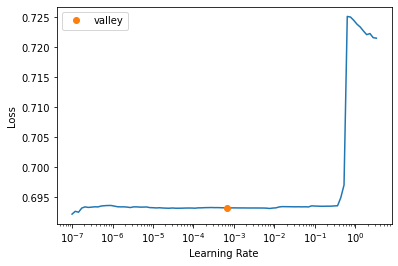

In [183]:
learn.lr_find()

In [184]:
learn.fit_one_cycle(10, 1e-3)

epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,0.693201,0.693156,0.496680,0.500000,00:01
1,0.693246,0.693143,0.496680,0.500000,00:01
2,0.693208,0.693222,0.496680,0.500000,00:01
3,0.693173,0.693127,0.496680,0.500000,00:01
4,0.693130,0.693321,0.496680,0.500000,00:01
5,0.693159,0.693128,0.496680,0.500000,00:01
6,0.693157,0.693172,0.496680,0.500000,00:01
7,0.693163,0.693150,0.496680,0.500000,00:01
8,0.693148,0.693156,0.496680,0.500000,00:01
9,0.693138,0.693155,0.496680,0.500000,00:01


In [123]:
train_df["label"].value_counts()

0    199
1    176
Name: label, dtype: int64

In [165]:
learn = TabularLearner(dls, simple_net, opt_func=SGD, loss_func=binary_cross_entropy, metrics=[accuracy, RocAucBinary()])

SuggestedLRs(valley=0.0831763744354248)

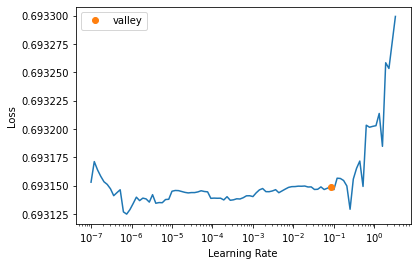

In [166]:
learn.lr_find()

In [168]:
learn.summary()

Sequential (Input shape: 256 x 20)
Layer (type)         Output Shape         Param #    Trainable 
                     256 x 200           
Linear                                    4200       True      
ReLU                                                           
Linear                                    40200      True      
ReLU                                                           
____________________________________________________________________________
                     256 x 50            
Linear                                    10050      True      
ReLU                                                           
Linear                                    2550       True      
ReLU                                                           
Linear                                    2550       True      
ReLU                                                           
____________________________________________________________________________
                     25

In [167]:
learn.fit_one_cycle(20, 1e-1)

epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,0.693153,0.693150,0.496680,0.500000,00:00
1,0.693149,0.693123,0.496680,0.500000,00:00
2,0.693190,0.693138,0.496680,0.500000,00:00
3,0.693186,0.693129,0.496680,0.500000,00:00
4,0.693166,0.693289,0.496680,0.500000,00:00
5,0.693178,0.693126,0.496680,0.500000,00:00
6,0.693188,0.693131,0.496680,0.500000,00:00
7,0.693193,0.693122,0.496680,0.500000,00:00
8,0.693175,0.693228,0.496680,0.500000,00:00
9,0.693189,0.693168,0.496680,0.500000,00:00


KeyboardInterrupt: 